In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

In [10]:
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session

# Reflect Tables into SQLAlchemy ORM

In [11]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [12]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [13]:
Base.classes.keys()

['measurement', 'station']

In [14]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
from sqlalchemy import inspect
inspector = inspect(engine)
sess = session.Session(bind=engine)

In [16]:
measurement_cols = inspector.get_columns('measurement')
measurement_cols

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [20]:
station_cols = inspector.get_columns('station')
station_cols

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [19]:
for col in measurement_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [21]:
for col in station_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [22]:
last_date_obs = sess.query(func.max(Measurement.date)).first()
last_date_obs

('2017-08-23')

In [23]:
twelve_months_before_last = dt.datetime.strptime(last_date_obs[0], "%Y-%m-%d") - dt.timedelta(days=365)
twelve_months_before_last

datetime.datetime(2016, 8, 23, 0, 0)

In [24]:
prcp_results = sess.query(Measurement.prcp, Measurement.date).filter((Measurement.date <= last_date_obs[0])
                                      & (Measurement.date > "2016-08-23")).all()
prcp_df = pd.DataFrame(data=prcp_results)

In [25]:
prcp_df_index_date = prcp_df.set_index('date')

In [26]:
prcp_df_index_date.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [40]:
xaxis = prcp_df_index_date.index
yaxis = prcp_df_index_date.prcp.values

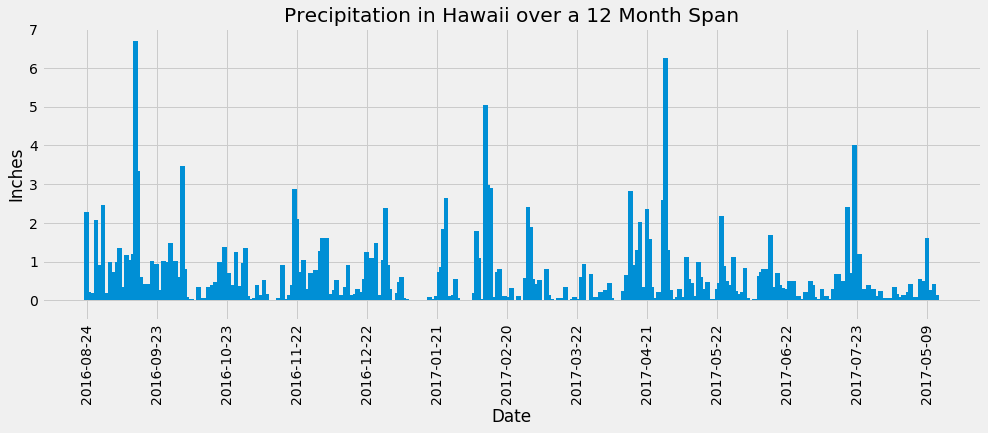

In [41]:
plt.figure(figsize=(15,5))
plt.bar(xaxis,yaxis, width=2)
plt.xticks(ticks= np.arange(0,365,30), rotation = 90)
plt.ylim(bottom=-0.5)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.title("Precipitation in Hawaii over a 12 Month Span")
plt.savefig("Images/precipitation.png", bbox_inches = "tight")

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data

In [43]:
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to show how many stations are available in this dataset?
sess.query(Station.station, Station.name).group_by(Station.station).all()

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

##### There are 9 stations in this dataset.

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sess.query(Station.station,Station.name, func.count(Measurement.prcp)).\
            filter(Station.station == Measurement.station).\
            group_by(Station.name).\
            order_by((func.count(Measurement.prcp)).desc()).all()

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

##### The most active station is USC00519281 and it has 2772 rows which means it has 2772 recorded observations for this dataset.

##### Note: Since func.count only counts non-null entries, the above counts are for precipitation observations.
##### Note: As we will see below, station USC00519281 also happens to be the most active station for temperature observations, but the  counts of temperature observations are different from the counts above.

In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sess.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()

[(53.0, 87.0, 73.09795396419437)]

##### The lowest temp recorded by station USC00519281 is 53 F; highest temp recorded is 87 F; and the average temp is approx. 73.1 F

In [47]:
# Choose the station with the highest number of temperature observations.
sess.query(Station.station, Station.name, func.count(Measurement.tobs)).\
            filter(Station.station == Measurement.station).\
            group_by(Station.station).\
            order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

##### Station USC00519281 has the highest number of temperature observations (2772 records.)

In [48]:
sess.query(func.max(Measurement.date)).first()

('2017-08-23')

In [49]:
dt.datetime.strptime('2017-08-23', '%Y-%m-%d') - dt.timedelta(days=365)

datetime.datetime(2016, 8, 23, 0, 0)

In [50]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = sess.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').\
                                 filter(Measurement.station == 'USC00519281').all()
temp_list = [temp for temp, in temp_query]
temp_list

[77.0,
 77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,
 70.0,
 62.0,
 62.0,
 63.0,
 65.0,

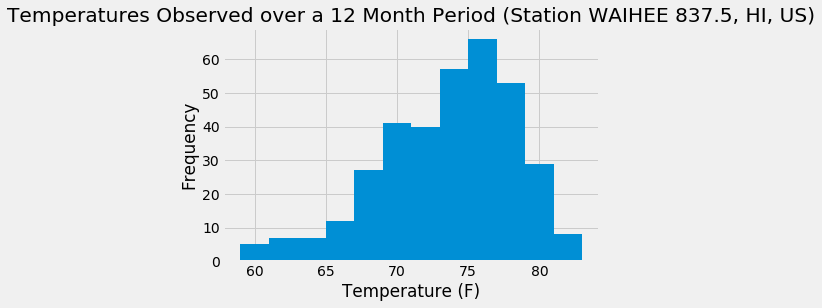

In [51]:
plt.hist(temp_list, bins=12)
plt.title("Temperatures Observed over a 12 Month Period (Station WAIHEE 837.5, HI, US)")
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.savefig("Images/station-histogram.png", bbox_inches = "tight")

# Temperature Analysis I

In [52]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

## Method 1: Pandas DataFrame

In [53]:
#Querying and converting date column in database from string to datetime object and storing in a list

dates_list = [date for date, in sess.query(Measurement.date).all()]
dates_list = [dt.datetime.strptime(x, '%Y-%m-%d') for x in dates_list]
dates_list

[datetime.datetime(2010, 1, 1, 0, 0),
 datetime.datetime(2010, 1, 2, 0, 0),
 datetime.datetime(2010, 1, 3, 0, 0),
 datetime.datetime(2010, 1, 4, 0, 0),
 datetime.datetime(2010, 1, 6, 0, 0),
 datetime.datetime(2010, 1, 7, 0, 0),
 datetime.datetime(2010, 1, 8, 0, 0),
 datetime.datetime(2010, 1, 9, 0, 0),
 datetime.datetime(2010, 1, 10, 0, 0),
 datetime.datetime(2010, 1, 11, 0, 0),
 datetime.datetime(2010, 1, 12, 0, 0),
 datetime.datetime(2010, 1, 14, 0, 0),
 datetime.datetime(2010, 1, 15, 0, 0),
 datetime.datetime(2010, 1, 16, 0, 0),
 datetime.datetime(2010, 1, 17, 0, 0),
 datetime.datetime(2010, 1, 18, 0, 0),
 datetime.datetime(2010, 1, 19, 0, 0),
 datetime.datetime(2010, 1, 20, 0, 0),
 datetime.datetime(2010, 1, 21, 0, 0),
 datetime.datetime(2010, 1, 22, 0, 0),
 datetime.datetime(2010, 1, 23, 0, 0),
 datetime.datetime(2010, 1, 24, 0, 0),
 datetime.datetime(2010, 1, 25, 0, 0),
 datetime.datetime(2010, 1, 26, 0, 0),
 datetime.datetime(2010, 1, 27, 0, 0),
 datetime.datetime(2010, 1, 28, 0

In [54]:
#Querying temp obs column in database and storing in a list

tobs_list = [obs for obs, in sess.query(Measurement.tobs).all()]
tobs_list

[65.0,
 63.0,
 74.0,
 76.0,
 73.0,
 70.0,
 64.0,
 68.0,
 73.0,
 64.0,
 61.0,
 66.0,
 65.0,
 68.0,
 64.0,
 72.0,
 66.0,
 66.0,
 69.0,
 67.0,
 67.0,
 71.0,
 67.0,
 76.0,
 68.0,
 72.0,
 70.0,
 67.0,
 66.0,
 67.0,
 69.0,
 67.0,
 67.0,
 64.0,
 69.0,
 73.0,
 73.0,
 69.0,
 69.0,
 69.0,
 71.0,
 61.0,
 69.0,
 63.0,
 64.0,
 65.0,
 67.0,
 68.0,
 65.0,
 76.0,
 75.0,
 66.0,
 70.0,
 72.0,
 73.0,
 70.0,
 71.0,
 72.0,
 72.0,
 69.0,
 70.0,
 73.0,
 72.0,
 73.0,
 70.0,
 71.0,
 68.0,
 70.0,
 72.0,
 69.0,
 68.0,
 74.0,
 72.0,
 72.0,
 73.0,
 74.0,
 73.0,
 73.0,
 74.0,
 74.0,
 74.0,
 71.0,
 72.0,
 75.0,
 75.0,
 75.0,
 75.0,
 73.0,
 73.0,
 71.0,
 71.0,
 68.0,
 70.0,
 71.0,
 74.0,
 71.0,
 75.0,
 76.0,
 75.0,
 75.0,
 76.0,
 76.0,
 76.0,
 77.0,
 77.0,
 73.0,
 74.0,
 76.0,
 76.0,
 80.0,
 74.0,
 77.0,
 77.0,
 76.0,
 77.0,
 78.0,
 78.0,
 75.0,
 73.0,
 77.0,
 76.0,
 77.0,
 77.0,
 78.0,
 75.0,
 77.0,
 77.0,
 77.0,
 76.0,
 75.0,
 77.0,
 77.0,
 77.0,
 78.0,
 76.0,
 78.0,
 76.0,
 77.0,
 78.0,
 77.0,
 78.0,
 78.0,
 79.0,

In [55]:
# Creating dataframe using both lists as columns

temp_df = pd.DataFrame({"Date": dates_list, "Temp Obs": tobs_list})
temp_df.head()

,Date,Temp Obs
0,2010-01-01,65.0
1,2010-01-02,63.0
2,2010-01-03,74.0
3,2010-01-04,76.0
4,2010-01-06,73.0


In [56]:
#Grouping dataframe by date column, specifically by months, and calculating mean

monthly_avg_temps = temp_df.groupby(temp_df["Date"].dt.month).mean()
monthly_avg_temps = monthly_avg_temps.rename(columns = {"Temp Obs": "Avg Temp"})
monthly_avg_temps

,Avg Temp
Date,
1,68.726115
2,69.442236
3,70.059067
4,72.357268
5,73.680900
6,74.944118
7,76.082408
8,76.412454
9,76.164865


##### The Date indices in the above dataframe represent months of the year from 1 (Jan) to 12 (Dec). 
##### The average observed temperature for the month of June across all years and all stations is: 
#### 74.94 F
##### Similarly, the average observed temperature for the month of December across all years and all stations is: 
#### 71.04 F

## Method 2: SQLAlchemy Queries

In [57]:
avg_temp_june = sess.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date) == "06").all()
avg_temp_dec = sess.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date) == "12").all()
june_val = [str for str, in avg_temp_june]
dec_val = [str for str, in avg_temp_dec]
print(f"The average temp in June for all stations across all years is {june_val[0]},\n"
      f"and the average temp in Dec for all stations across all years is {dec_val[0]}")

The average temp in June for all stations across all years is 74.94411764705882,
and the average temp in Dec for all stations across all years is 71.04152933421226


##### The temperatures from method 1 are equivalent to the temperatures obtained using method 2.

## T-test to determine if there is a statistical difference between the June and December mean temps

#### Since the t-test requires the raw data to be input into it's parameters as arrays, we need to create a list of all June and July temps

### Method 1: SQL Queries

In [58]:
#Finding counts of June and Dec temp observations because arrays have to be equal length in order to run t-test.

june_count = sess.query(Measurement.tobs).\
                filter(func.strftime('%m', Measurement.date) == "06").count()
dec_count = sess.query(Measurement.tobs).\
                filter(func.strftime("%m", Measurement.date) == "12").count()
print(june_count, dec_count)

1700 1517


In [59]:
#Since December has less observations than June, we will limit our query to the December count = 1517

june_temps = sess.query(Measurement.tobs).\
                filter(func.strftime("%m", Measurement.date) == "06").limit(1517).all()
june_temp_list = [str for str, in june_temps]
dec_temps = sess.query(Measurement.tobs).\
                filter(func.strftime("%m", Measurement.date) == "12").limit(1517).all()
dec_temp_list = [str for str, in dec_temps]

In [60]:
import scipy.stats as sts
sts.ttest_rel(june_temp_list, dec_temp_list)

Ttest_relResult(statistic=34.804545051754815, pvalue=1.4623155269997529e-195)

### Method 2: Pandas DataFrame

In [61]:
# Recall temp_df
temp_df.head()

,Date,Temp Obs
0,2010-01-01,65.0
1,2010-01-02,63.0
2,2010-01-03,74.0
3,2010-01-04,76.0
4,2010-01-06,73.0


In [62]:
# Filter dataframe for rows where the month value in the Date column is equal to 6 (for June) or equal to 12 (for Dec)
# Then extract just the temperatures

june_df = temp_df.loc[temp_df["Date"].dt.month.values == 6]
print(june_df["Temp Obs"].values[0:1517])
dec_df = temp_df.loc[temp_df["Date"].dt.month.values == 12]
print(dec_df["Temp Obs"].values)

[78. 76. 78. ... 72. 74. 70.]
[76. 74. 74. ... 69. 65. 65.]


In [63]:
sts.ttest_rel(june_df["Temp Obs"].values[0:1517], dec_df["Temp Obs"].values)

Ttest_relResult(statistic=34.804545051754815, pvalue=1.4623155269997529e-195)

### Our t-test yields a t-statistic = 34.8 and a p-value = 1.46 x 10^-195, which is nearly equivalent to 0. 
###  We can conclude that, for all stations across all years in the data set, the difference in mean temperatures between June and December is statistically significant.

# Bonus Challenge Assignment - Temp Analysis II

### Trip length =  7 days
### Trip start date = 2018-06-23
### Trip end date = 2018-06-29

In [64]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return sess.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [65]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

output = calc_temps('2017-06-23', '2017-06-29')
min_temp = output[0][0]
avg_temp = output[0][1]
max_temp = output[0][2]
print(f"The min, avg, and max temps for the time period 1 year before my trip are: {min_temp} F, {round(avg_temp,3)} F, and {max_temp} F, respectively")

The min, avg, and max temps for the time period 1 year before my trip are: 71.0 F, 77.302 F, and 82.0 F, respectively


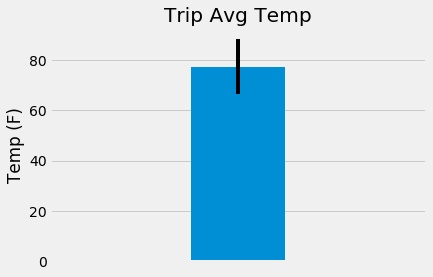

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_xticks([])
ax.bar(0.5, avg_temp, yerr = max_temp - min_temp, width=0.25)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.savefig("Images/Trip_Avg_Temp.png", bbox_inches = "tight")
plt.show()

In [67]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_query = sess.query(func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, 
                        Station.elevation).\
                        filter(Measurement.station == Station.station).\
                        filter(Measurement.date >= '2017-06-23').\
                        filter(Measurement.date <= '2017-06-29').\
                        group_by(Measurement.station).\
                        order_by(Measurement.prcp.desc()).all()
rain_data = []
for rain, station, name, lat, lng, elev in rain_query:
    rain_data.append({"Rain Total (in)": rain, 
                    "Station": station,
                    "Name": name,
                    "Latitude": lat,
                    "Longitutde": lng,
                    "Elevation": elev})
rain_df = pd.DataFrame(rain_data)
rain_df

,Rain Total (in),Station,Name,Latitude,Longitutde,Elevation
0,1.40,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.57,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.05,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,0.06,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,0.14,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
6,NaN,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


In [73]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return sess.query(*sel).filter(func.strftime('%m-%d', Measurement.date) == date).all()
    
daily_normals("01-02")

[(60.0, 69.39622641509433, 77.0)]

In [74]:
trip_dates_list = ["06-23", "06-24", "06-25", "06-26", "06-27", "06-28", "06-29"]
normals = []
for date in trip_dates_list:
    normals.append(daily_normals(date)[0])
normals

[(68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0)]

In [76]:
normals_data = []
for tmin, tavg, tmax in normals:
    normals_data.append({"Min Temp": tmin,
                        "Max Temp": tmax,
                        "Avg Temp": tavg})

normals_df = pd.DataFrame(normals_data)
normals_df["Date"] = trip_dates_list

In [78]:
normals_df = normals_df.set_index("Date")

In [79]:
normals_df

,Min Temp,Max Temp,Avg Temp
Date,,,
06-23,68.0,80.0,74.543860
06-24,68.0,84.0,74.964286
06-25,68.0,80.0,74.103448
06-26,67.0,82.0,74.214286
06-27,66.0,81.0,75.017857
06-28,69.0,80.0,74.886792
06-29,67.0,80.0,74.915254


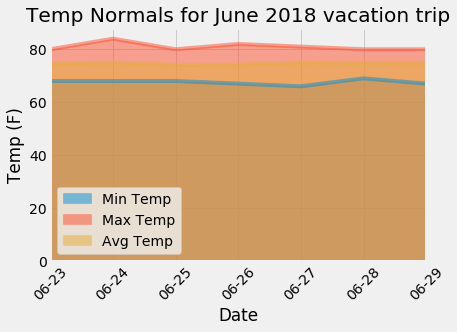

In [81]:
normals_df.plot.area(stacked = False)
plt.title("Temp Normals for June 2018 vacation trip")
plt.ylabel("Temp (F)")
plt.xticks(rotation = 45)
plt.xlim(0, 6)
plt.savefig("Images/Trip_Temp_Normals.png", bbox_inches = "tight")